In [12]:
import numpy as np
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import get_poles, load_wordnet_axes, get_glove_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

In [20]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [3]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab)
adj_poles = get_poles(glove_vecs, axes)

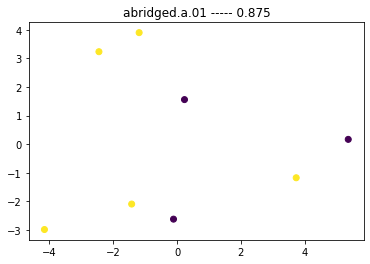

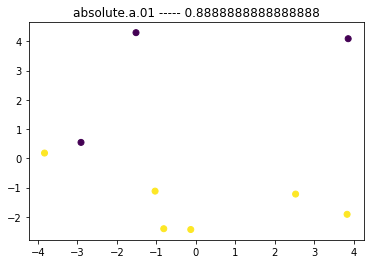

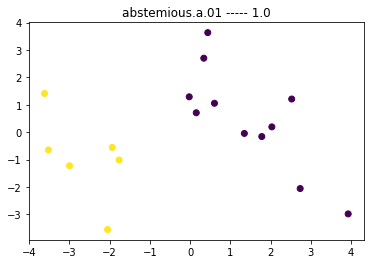

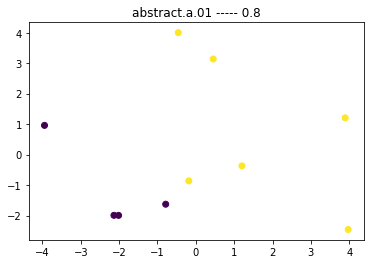

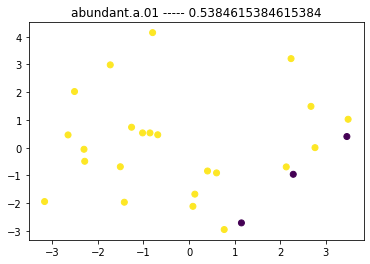

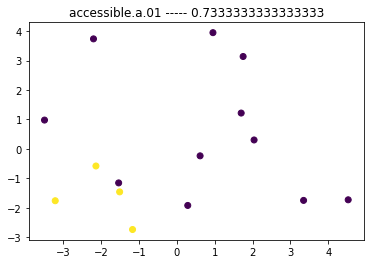

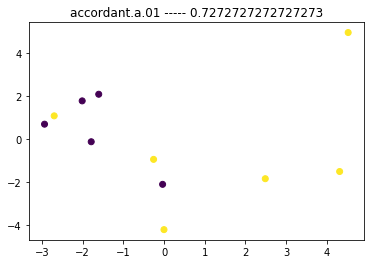

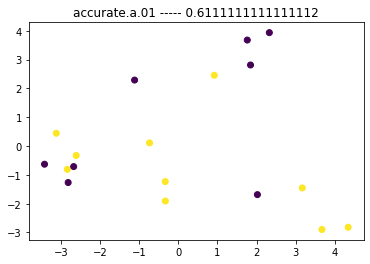

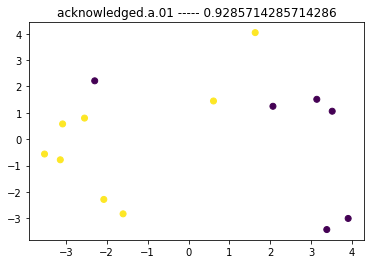

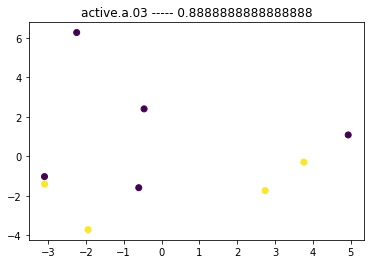

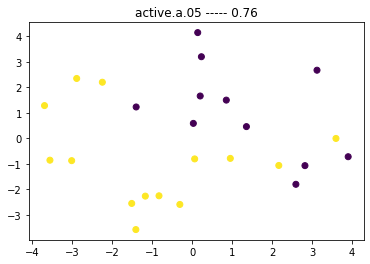

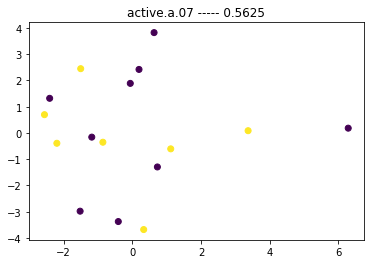

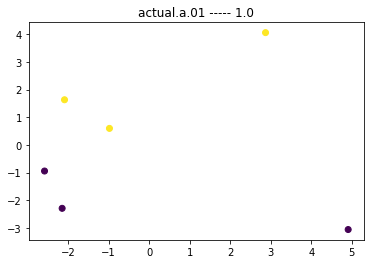

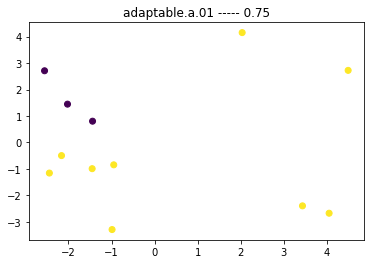

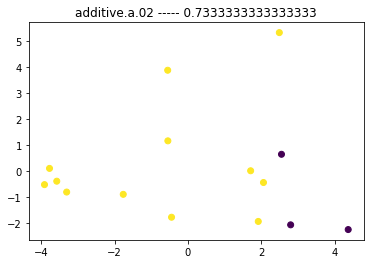

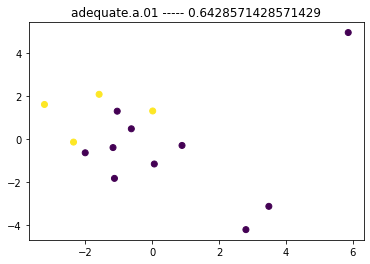

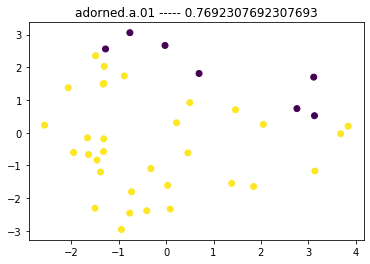

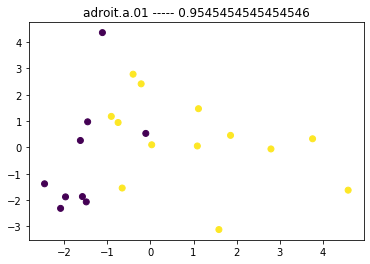

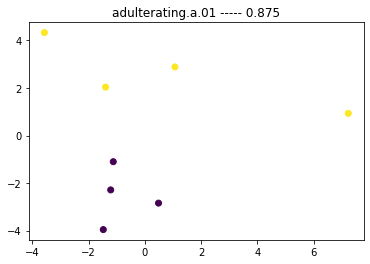

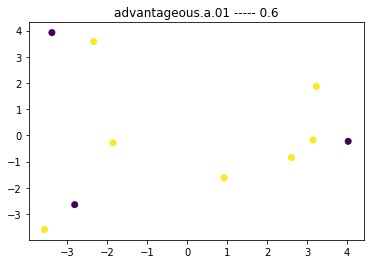

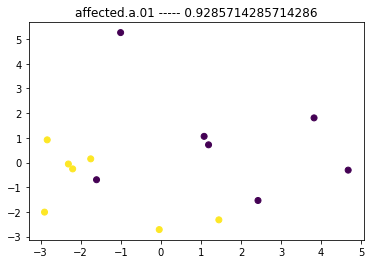

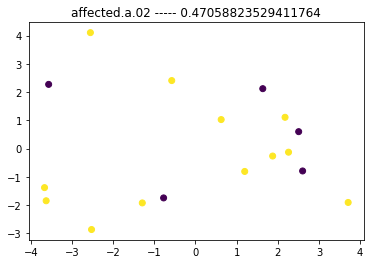

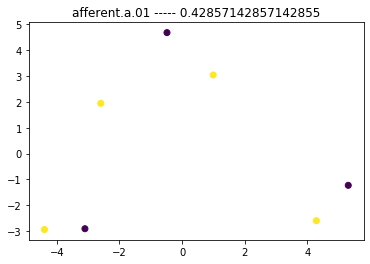

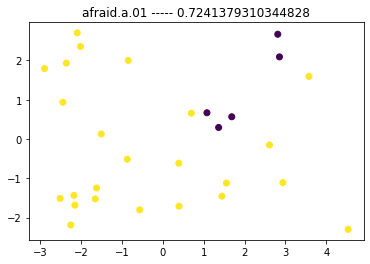

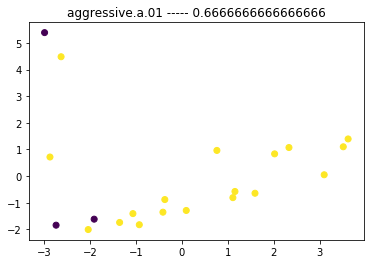

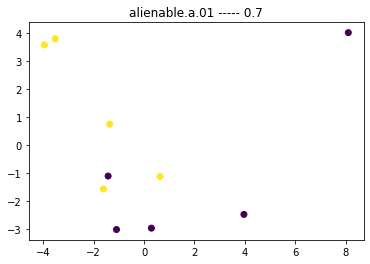

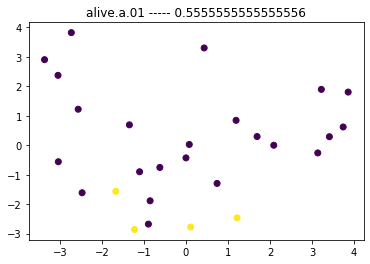

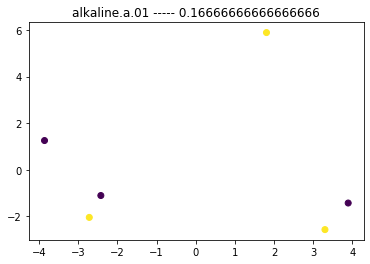

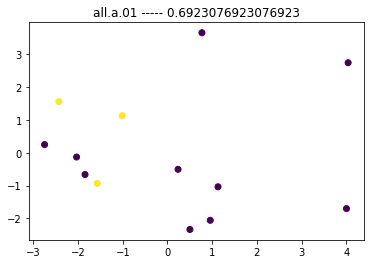

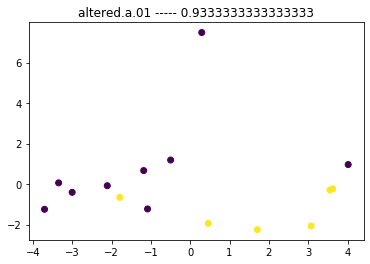

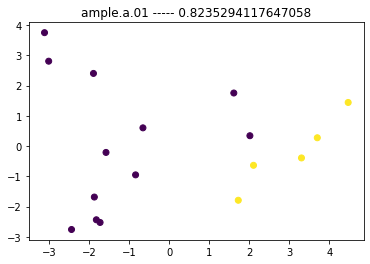

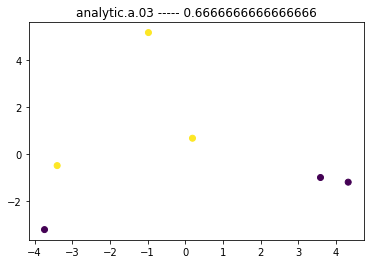

In [117]:
for i, pole in enumerate(adj_poles): 
    #if not pole.startswith('theoretical') and not pole.startswith('healthy'): continue
    left_vecs, right_vecs = adj_poles[pole]
    this_adj_matrix = np.concatenate((left_vecs, right_vecs), axis=0)
    this_adj_scores = [1] * left_vecs.shape[0] + [0] * right_vecs.shape[0]
    
    pca = PCA(n_components=6)
    this_adj_matrix = pca.fit_transform(this_adj_matrix)
    plt.scatter(this_adj_matrix[:, 0], this_adj_matrix[:, 1], c=this_adj_scores)
    plt.title(pole + ' ----- ' + str(accuracies[pole]))
    plt.show()
    if i > 30: 
        break

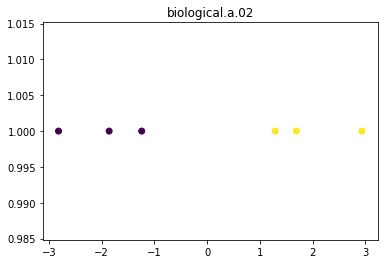

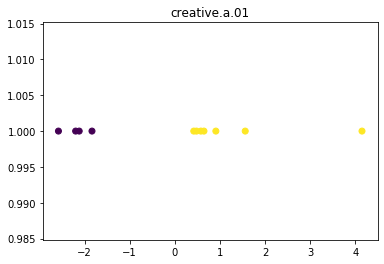

In [29]:
for i, pole in enumerate(adj_poles): 
    if not pole.startswith('creative') and not pole.startswith('biological'): continue
    left_vecs, right_vecs = adj_poles[pole]
    this_adj_matrix = np.concatenate((left_vecs, right_vecs), axis=0)
    this_adj_scores = [1] * left_vecs.shape[0] + [0] * right_vecs.shape[0]
    
    clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    this_adj_matrix = scaler.fit_transform(this_adj_matrix)
    this_adj_matrix = pca.fit_transform(this_adj_matrix)
    clf.fit(this_adj_matrix, this_adj_scores)
    this_adj_matrix = clf.transform(this_adj_matrix)
    plt.scatter(this_adj_matrix, [1]*this_adj_matrix.shape[0], c=this_adj_scores)
    plt.title(pole)
    plt.show()
#     if i > 20: 
#         break

### Gaussian assumption

In [125]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab
import random
from sklearn.preprocessing import StandardScaler

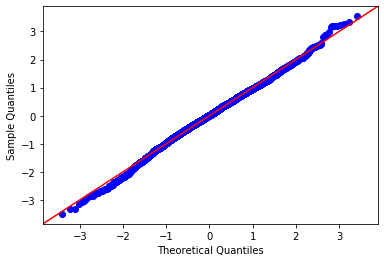

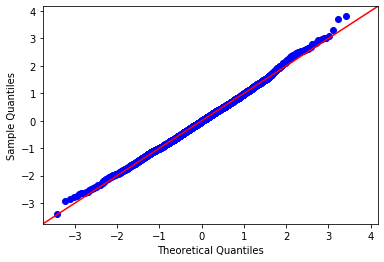

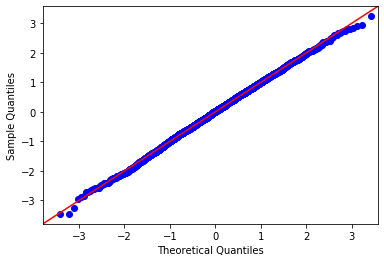

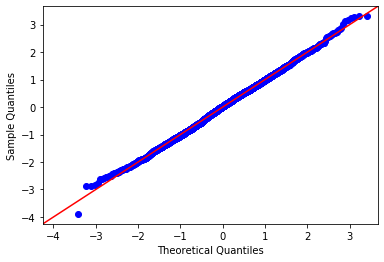

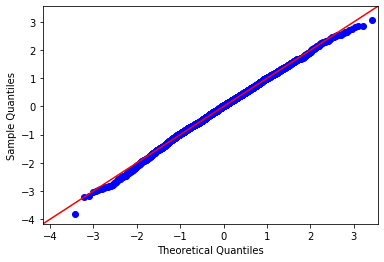

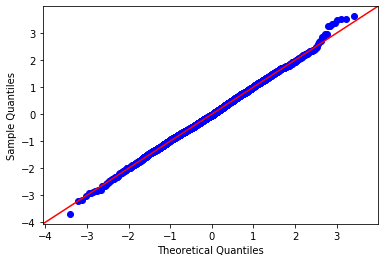

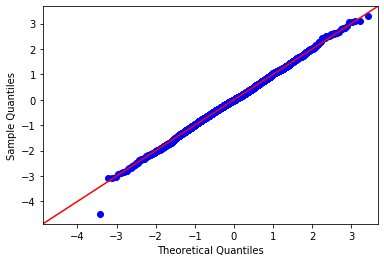

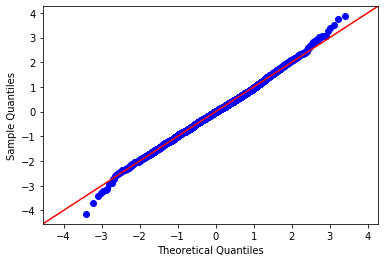

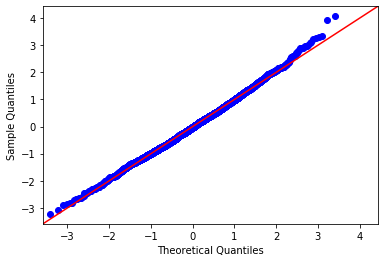

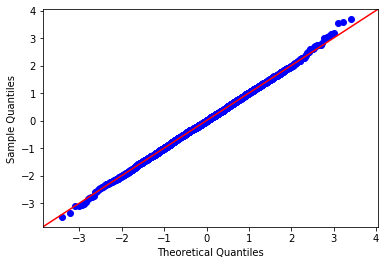

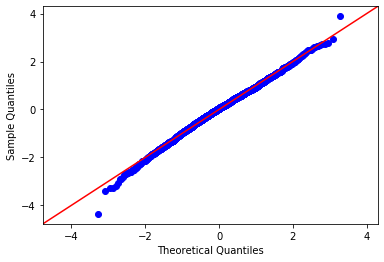

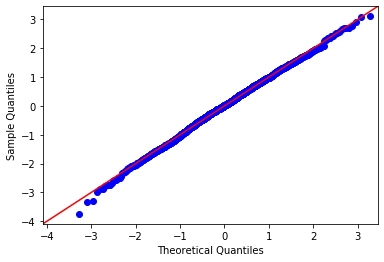

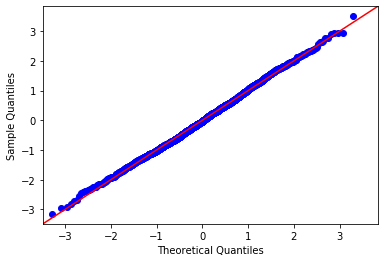

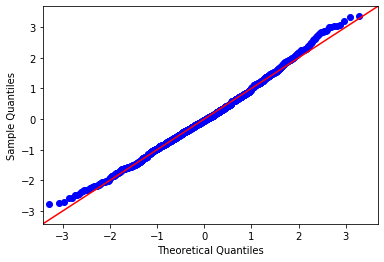

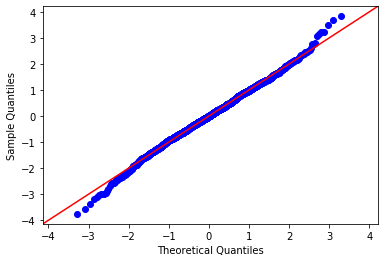

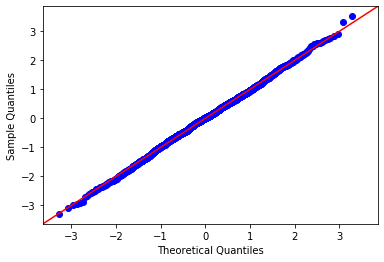

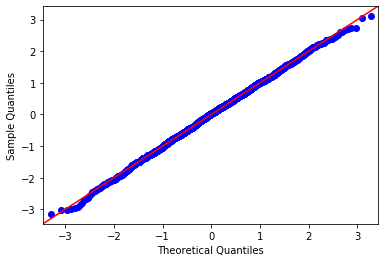

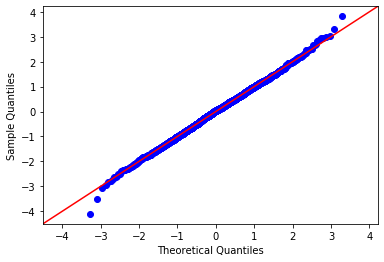

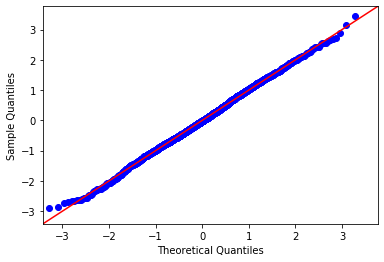

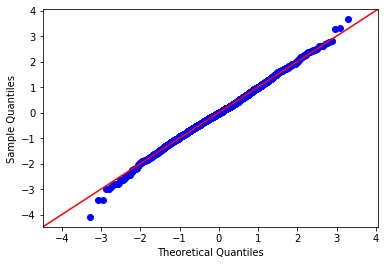

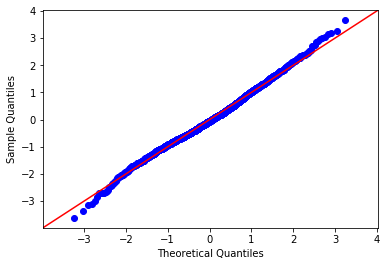

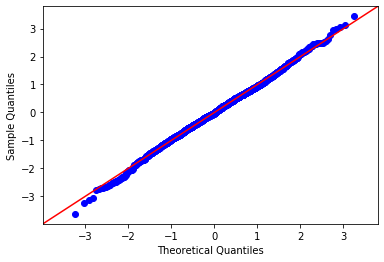

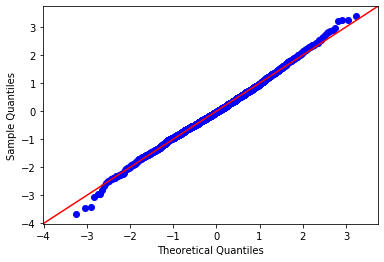

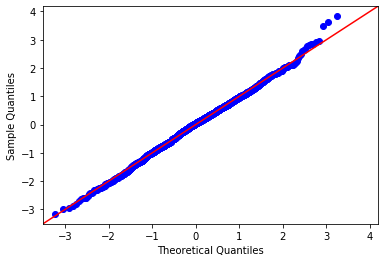

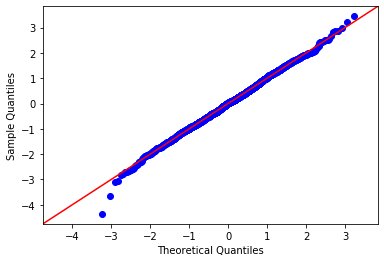

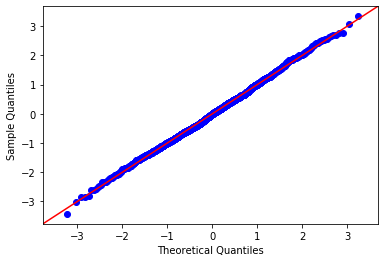

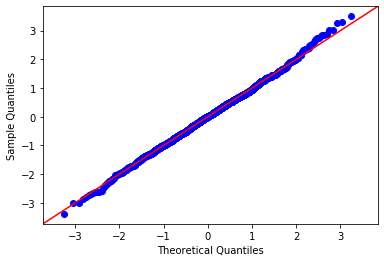

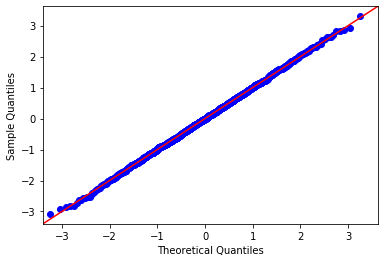

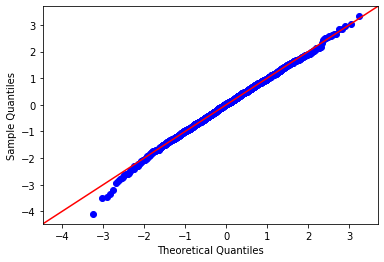

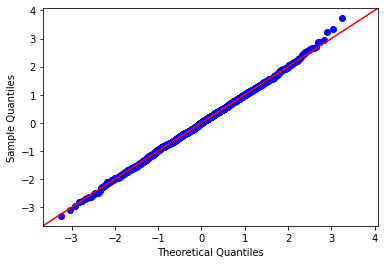

In [126]:
for c in vad: 
    word_matrix = np.load(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_words.npy')
    scaler = StandardScaler()
    word_matrix = scaler.fit_transform(word_matrix)
    idx = random.sample(range(word_matrix.shape[1]), 10)
    for i in idx: 
        sm.qqplot(word_matrix[:, i], line='45')
        pylab.show()

## NRC VAD

Pre-trained GloVe embeddings

### LDA VAD

In [35]:
def load_lexicon_matrix(c, lexicon_dict, lexicon_name):
    scores = lexicon_dict[c]
    t_matrix = np.load(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '.npy')
    word_order = []
    colors = []
    with open(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_vocab.txt', 'r') as infile: 
        for line in infile: 
            word = line.strip()
            word_order.append(word)
            if word in scores['high']: 
                colors.append('high')
            elif word in scores['low']: 
                colors.append('low')
    return t_matrix, word_order, colors

def load_inputs(file_path, lexicon_name): 
    with open(file_path, 'r') as infile:
        lexicon_dict = json.load(infile)
    adj_matrix = np.load(LOGS + 'semantics_val/wordnet_axes.npy')
    score_matrices = {}
    word_matrices = {} 
    word_orders = {}
    for c in lexicon_dict: 
        score_matrices[c] = np.load(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_scores.npy')
        word_matrices[c] = np.load(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_words.npy')
        word_order = []
        with open(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_vocab.txt', 'r') as infile: 
            for line in infile: 
                word = line.strip()
                word_order.append(word)
        word_orders[c] = word_order
    return adj_matrix, score_matrices, word_matrices, word_orders

def get_axes(): 
    axes = []
    with open(LOGS + 'semantics_val/axes_order.txt', 'r') as infile: 
        for line in infile: 
            axes.append(line.strip())
    return axes

In [36]:
with open(DATA + 'semantics/cleaned/nrc_vad.json', 'r') as infile:
    vad = json.load(infile)
# same order as validate_semantics.py
axes = get_axes()
for c in vad: 
    print(c)
    print('TOP WORDS')
    t_matrix, word_order, colors = load_lexicon_matrix(c, vad, 'vad')
    t_matrix = t_matrix.T
    max_ind = np.argpartition(t_matrix, -5)[0][-5:]
    for ind in max_ind: 
        print(word_order[int(ind)], colors[int(ind)])
    min_id = np.argpartition(t_matrix, 5)[0][:5]
    for ind in min_id:
        print(word_order[int(ind)], colors[int(ind)])
            
    print('TOP ADJECTIVES')
    t_axes_matrix = np.load(LOGS + 'semantics_val/vad/' + c + '_axes.npy')
    max_ind = np.argpartition(t_axes_matrix.T, -5)[0][-5:]
    for ind in max_ind: 
        print(axes[int(ind)], t_axes_matrix[int(ind)], 'high')
    min_id = np.argpartition(t_axes_matrix.T, 5)[0][:5]
    for ind in min_id:
        print(axes[int(ind)], t_axes_matrix[int(ind)], 'low')

    vals = []
    dims = []
    for i, adj in enumerate(axes): 
        if (i - 1) % 2 == 0:
            if t_axes_matrix[i][0] * t_axes_matrix[i-1][0] > 0: continue # both on same side
            val = abs(t_axes_matrix[i][0] - t_axes_matrix[i-1][0])
            vals.append(val)
            dims.append((axes[i], t_axes_matrix[i][0], axes[i-1], t_axes_matrix[i-1][0]))
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

valence
TOP WORDS
partnership high
gifts high
friendship high
award high
excellence high
incompetence low
psychotic low
stench low
bastards low
inefficiency low
TOP ADJECTIVES
ample.a.01_synonym [2.70008685] high
happy.a.01_synonym [2.85106875] high
cursed.a.01_antonym [2.93056569] high
nice.a.01_synonym [3.40294148] high
sound.a.01_synonym [3.00034989] high
beautiful.a.01_antonym [-2.52613916] low
pardonable.a.01_antonym [-3.14290308] low
competent.a.01_antonym [-2.80301221] low
toxic.a.01_synonym [-2.70565599] low
soluble.a.02_antonym [-2.47656364] low
1st max: ('nice.a.01_antonym', -1.929723272398773, 'nice.a.01_synonym', 3.402941482520492)
2nd max: ('happy.a.01_antonym', -1.747616152777555, 'happy.a.01_synonym', 2.851068753439934)
3rd max: ('gracious.a.01_antonym', -1.8737672349544237, 'gracious.a.01_synonym', 2.5471492721861235)

arousal
TOP WORDS
adrenaline high
fury high
maniac high
thrill high
orgy high
beige low
blue low
pew low
parchment low
crepe low
TOP ADJECTIVES
tractable

Correlation between LDA scores and VAD scores

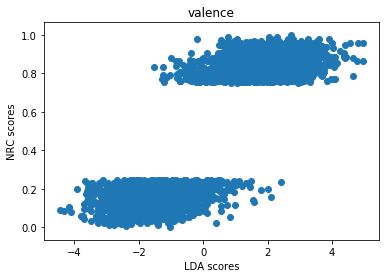

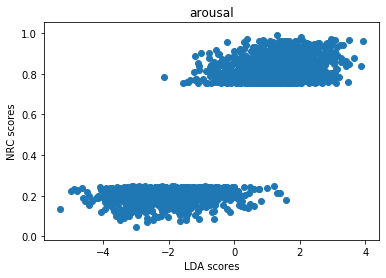

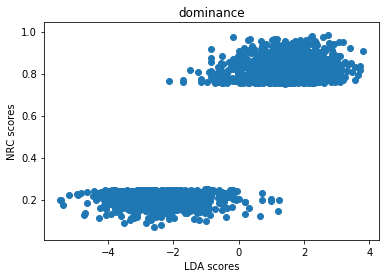

In [197]:
data_file = DATA + 'semantics/NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon.txt'
nrc_scores = defaultdict(dict)
with open(data_file, 'r') as infile: 
    for line in infile: 
        contents = line.strip().split('\t')
        word = contents[0]
        val = float(contents[1])
        aro = float(contents[2])
        dom = float(contents[3])
        nrc_scores['valence'][word] = val
        nrc_scores['arousal'][word] = aro
        nrc_scores['dominance'][word] = dom
for c in vad: 
    t_matrix, word_order, colors = load_vad_matrix(c, vad)
    x = []
    y = []
    for idx, w in enumerate(word_order): 
        x.append(t_matrix[int(idx)][0])
        y.append(nrc_scores[c][w])
    plt.scatter(x, y)
    plt.xlabel('LDA scores')
    plt.ylabel('NRC scores')
    plt.title(c)
    plt.show()

### FrameAxis VAD

In [90]:
with open(LOGS + 'semantics_val/vad/frameaxis.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

valence
1st max: ('nice.a.01', 0.1712394591439324, -0.08064718106103262, 0.0905922780828998)
2nd max: ('healthy.a.01', 0.17019110721604408, -0.07596873796571467, 0.09422236925032941)
3rd max: ('faithful.a.01', 0.15717166239716235, -0.06718899349221834, 0.08998266890494402)

arousal
1st max: ('moderate.a.01', 0.11165093668238923, 0.037376548883378984, -0.07427438779901024)
2nd max: ('wholesome.a.01', 0.1031880982818658, 0.051754790109891605, -0.051433308171974196)
3rd max: ('happy.a.01', 0.0992123746620069, 0.05011145279932012, -0.04910092186268678)

dominance
1st max: ('important.a.01', 0.18249409616347761, -0.0878713518350423, 0.09462274432843532)
2nd max: ('superior.a.01', 0.17615962826717357, -0.1158489739274859, 0.060310654339687686)
3rd max: ('steady.a.01', 0.17036502902701037, -0.07974522573945234, 0.09061980328755803)



In [91]:
with open(LOGS + 'semantics_val/vad/frameaxis_scaler.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

valence
1st max: ('healthy.a.01', 0.1387720714900661, 0.021315455143408598, 0.1600875266334747)
2nd max: ('good.a.01', 0.12685681522740844, 0.05438153846788342, 0.18123835369529187)
3rd max: ('beautiful.a.01', 0.12560085377879893, -0.09399408962179653, 0.03160676415700238)

arousal
1st max: ('moderate.a.01', 0.09927739196794323, 0.09608770567802596, -0.003189686289917266)
2nd max: ('mild.a.01', 0.08375809501949896, 0.03407066785626966, -0.04968742716322931)
3rd max: ('cacophonous.a.01', 0.08109598927546983, -0.1461548336919746, -0.06505884441650477)

dominance
1st max: ('superior.a.01', 0.13839874082635145, -0.06977210184986712, 0.06862663897648431)
2nd max: ('hard.a.03', 0.11537201074458647, 0.04108504827557999, 0.15645705902016646)
3rd max: ('steady.a.01', 0.11207067728570039, 0.049387517608168875, 0.16145819489386926)



In [92]:
with open(LOGS + 'semantics_val/vad/frameaxis_pca.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

valence
1st max: ('happy.a.01', 0.6275095829291235, -0.40930513130387564, 0.21820445162524787)
2nd max: ('beautiful.a.01', 0.5308948524554892, -0.4428131661981206, 0.0880816862573686)
3rd max: ('pleasing.a.01', 0.5190900100696851, -0.33842672667588153, 0.18066328339380366)

arousal
1st max: ('happy.a.01', 0.421809842883486, 0.19436964116985014, -0.22744020171363588)
2nd max: ('moderate.a.01', 0.408494008550023, 0.38038402893378903, -0.02810997961623396)
3rd max: ('mild.a.01', 0.37923318209329954, 0.13864512874881937, -0.24058805334448016)

dominance
1st max: ('superior.a.01', 0.6041935827918463, -0.332967426783618, 0.2712261560082283)
2nd max: ('important.a.01', 0.48066201922972085, -0.47385752274596726, 0.006804496483753571)
3rd max: ('united.a.01', 0.48013009668863876, -0.18303728562781058, 0.2970928110608282)



## Occupations

In [199]:
with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile:
    lexicon_dict = json.load(infile)
# same order as validate_semantics.py
axes = get_axes()
lexicon_name = 'occupations'
for c in lexicon_dict: 
    print(c)
    print('TOP WORDS')
    t_matrix, word_order, colors = load_lexicon_matrix(c, lexicon_dict, lexicon_name)
    t_matrix = t_matrix.T
    max_ind = np.argpartition(t_matrix, -5)[0][-5:]
    for ind in max_ind: 
        print(word_order[int(ind)], colors[int(ind)])
    min_id = np.argpartition(t_matrix, 5)[0][:5]
    for ind in min_id:
        print(word_order[int(ind)], colors[int(ind)])
            
    print('TOP ADJECTIVES')
    t_axes_matrix = np.load(LOGS + 'semantics_val/' + lexicon_name + '/' + c + '_axes.npy')
    max_ind = np.argpartition(t_axes_matrix.T, -5)[0][-5:]
    for ind in max_ind: 
        print(axes[int(ind)], t_axes_matrix[int(ind)], 'high')
    min_id = np.argpartition(t_axes_matrix.T, 5)[0][:5]
    for ind in min_id:
        print(axes[int(ind)], t_axes_matrix[int(ind)], 'low')

    vals = []
    dims = []
    for i, adj in enumerate(axes): 
        if adj == 'creative.a.01_antonym' or adj == 'scholarly.a.01_antonym': 
            print("------", adj, axes[i], t_axes_matrix[i][0], axes[i-1], t_axes_matrix[i-1][0])
        if (i - 1) % 2 == 0:
            if t_axes_matrix[i][0] * t_axes_matrix[i-1][0] > 0: continue # both on same side
            val = abs(t_axes_matrix[i][0] - t_axes_matrix[i-1][0])
            vals.append(val)
            dims.append((axes[i], t_axes_matrix[i][0], axes[i-1], t_axes_matrix[i-1][0]))
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
TOP WORDS
civil engineers high
mechanical engineers high
taxi drivers high
roofers high
construction laborers high
occupational therapists low
nursing assistants low
dental assistants low
medical assistants low
nurse practitioners low
TOP ADJECTIVES
shod.a.01_synonym [2.02595163] high
combustible.a.01_antonym [2.04080013] high
permeable.a.01_synonym [2.10744158] high
piano.a.01_antonym [2.13640752] high
shod.a.01_antonym [2.16413812] high
clear.a.01_antonym [-1.3822279] low
probable.a.01_synonym [-1.62086364] low
anterior.a.01_synonym [-1.65224824] low
foreign.a.01_antonym [-1.21849777] low
exterior.a.01_antonym [-1.11597363] low
------ creative.a.01_antonym creative.a.01_antonym 0.40590457384895823 creative.a.01_synonym 0.009811853454095298
1st max: ('thick.a.03_antonym', -0.7388154801434033, 'thick.a.03_synonym', 1.3094208807987968)
2nd max: ('functional.a.01_antonym', -0.8318995758983614, 'functional.a.01_synonym', 1.1101713256641053)
3rd max: ('frequent.a.01_antonym', -1.032

In [73]:
with open(LOGS + 'semantics_val/occupations/lda.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
1st max: ('immediate.a.03', 7.141906050275281e+30, -3.236077318198057e+30, -1.0377983368473338e+31)
2nd max: ('politic.a.01', 1.8358319091259656e+30, 6.742816530428546e+29, -1.1615502560831108e+30)
3rd max: ('continental.a.04', 1.7694671769315534e+30, -1.3391875563856276e+29, 1.6355484212929905e+30)

stem
1st max: ('immediate.a.03', 2.0015516870747027e+30, -6.648544096301484e+30, -8.650095783376186e+30)
2nd max: ('convincing.a.01', 1.45144188655112e+30, -2.509128440507727e+30, -3.960570327058847e+30)
3rd max: ('leeward.a.01', 1.0966579205163179e+30, 3.3807545358255874e+29, 1.4347333740988765e+30)

art
1st max: ('immediate.a.03', 1.6767342016205947e+30, -6.265671088574587e+30, -7.942405290195182e+30)
2nd max: ('continental.a.04', 1.355002201700434e+30, 6.9470000193552815e+28, 1.424472201893987e+30)
3rd max: ('politic.a.01', 8.987034779715015e+29, 7.158252297904181e+28, -8.271209549924597e+29)

health
1st max: ('immediate.a.03', 4.2397373836796004e+30, -7.893454491472272e+30, -3.6

In [81]:
with open(LOGS + 'semantics_val/occupations/frameaxis.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
1st max: ('dominant.a.01', 0.12892956647112358, -0.1975262403137613, -0.0685966738426377)
2nd max: ('constructive.a.01', 0.09214067883626403, 0.17290491366502714, 0.0807642348287631)
3rd max: ('afferent.a.01', 0.08773957089807664, 0.004238166684605841, -0.0835014042134708)

stem
1st max: ('biological.a.02', 0.11161605673559367, -0.019057633410175176, 0.0925584233254185)
2nd max: ('functional.a.01', 0.10568012005243375, 0.03638561787763324, 0.142065737930067)
3rd max: ('basic.a.01', 0.09148565261600906, 0.03207285982236588, 0.12355851243837494)

art
1st max: ('theoretical.a.02', 0.1401593479471962, -0.11910189894055992, 0.02105744900663627)
2nd max: ('pleasing.a.01', 0.13470444665696998, 0.015533291555532566, 0.15023773821250255)
3rd max: ('colorful.a.01', 0.1288572988697808, 0.019382609412581984, 0.1482399082823628)

health
1st max: ('healthy.a.01', 0.19576429531063771, 0.09975566461910883, -0.0960086306915289)
2nd max: ('original.a.03', 0.15809624012899032, 0.1396559016116933, 

In [82]:
with open(LOGS + 'semantics_val/occupations/frameaxis_scaler.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
1st max: ('dominant.a.01', 0.1061731083275852, -0.168950988517211, -0.0627778801896258)
2nd max: ('afferent.a.01', 0.07948144891386731, 0.059715874064549083, -0.019765574849318224)
3rd max: ('exempt.a.01', 0.07352108095369936, 0.06310893095583209, -0.01041214999786727)

stem
1st max: ('functional.a.01', 0.09145133488365478, 0.0271409895885415, 0.11859232447219628)
2nd max: ('biological.a.02', 0.08121248075167883, 0.00028547841787642864, 0.08149795916955527)
3rd max: ('basic.a.01', 0.07987383341273024, -0.05563912177224964, 0.0242347116404806)

art
1st max: ('colorful.a.01', 0.1081266074500153, 0.022342216640193212, 0.13046882409020852)
2nd max: ('theoretical.a.02', 0.10013389962195332, -0.10599443082133866, -0.0058605311993853455)
3rd max: ('pleasing.a.01', 0.09341551533843422, -0.01164792574883901, 0.08176758958959521)

health
1st max: ('healthy.a.01', 0.1446214239197976, 0.15772268550912033, 0.013101261589322727)
2nd max: ('colorful.a.01', 0.10393397544308501, 0.09165329443353

In [83]:
with open(LOGS + 'semantics_val/occupations/frameaxis_pca.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
1st max: ('exempt.a.01', 0.5296726437218521, 0.5295495813439035, -0.0001230623779486173)
2nd max: ('current.a.01', 0.49895662042700867, 0.23632615437683774, -0.26263046605017093)
3rd max: ('publicized.a.01', 0.4606593406666794, 0.5228651937835876, 0.062205853116908225)

stem
1st max: ('basic.a.01', 0.43636138705967004, -0.2927776346740906, 0.1435837523855794)
2nd max: ('theoretical.a.02', 0.394460180232838, -0.17585521284793407, -0.5703153930807721)
3rd max: ('physical.a.01', 0.38976415247950486, -0.0944419974526637, -0.48420614993216854)

art
1st max: ('major.a.01', 0.619727456616766, -0.31301189518384887, 0.3067155614329171)
2nd max: ('theoretical.a.02', 0.5752951203240881, -0.49203275752718467, 0.08326236279690351)
3rd max: ('pleasing.a.01', 0.5103548865324596, -0.16549459936387712, 0.3448602871685826)

health
1st max: ('healthy.a.01', 0.618671578123689, 0.6220709160082645, 0.003399337884575452)
2nd max: ('mindful.a.01', 0.47537570312067534, 0.22212331166848187, -0.2532523914

In [116]:
with open(LOGS + 'semantics_val/occupations/frameaxis_scaler.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print(c)
    vals = []
    dims = []
    for pole in biases[c]: 
        if accuracies[pole] < 0.5: continue
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()

gender
1st max: ('dominant.a.01', 0.1061731083275852, -0.168950988517211, -0.0627778801896258)
2nd max: ('exempt.a.01', 0.07352108095369936, 0.06310893095583209, -0.01041214999786727)
3rd max: ('publicized.a.01', 0.07263308684031822, 0.09389747775032342, 0.0212643909100052)

stem
1st max: ('functional.a.01', 0.09145133488365478, 0.0271409895885415, 0.11859232447219628)
2nd max: ('biological.a.02', 0.08121248075167883, 0.00028547841787642864, 0.08149795916955527)
3rd max: ('basic.a.01', 0.07987383341273024, -0.05563912177224964, 0.0242347116404806)

art
1st max: ('colorful.a.01', 0.1081266074500153, 0.022342216640193212, 0.13046882409020852)
2nd max: ('pleasing.a.01', 0.09341551533843422, -0.01164792574883901, 0.08176758958959521)
3rd max: ('single.a.03', 0.09185801759276291, 0.1728242144177371, 0.2646822320105)

health
1st max: ('healthy.a.01', 0.1446214239197976, 0.15772268550912033, 0.013101261589322727)
2nd max: ('colorful.a.01', 0.10393397544308501, 0.09165329443353475, -0.01228068

### Playground

See if all axes are similar in quality with a few test examples. 

In [207]:
adj_matrix, score_matrices, word_matrices, word_order = load_inputs(DATA + 'semantics/cleaned/occupations.json', 
                                                                    'occupations')
axes = get_axes()

In [209]:
microframe = None
for i, adj in enumerate(axes): 
    if adj == 'creative.a.01_antonym': 
        pole1 = adj_matrix[i]
        pole2 = adj_matrix[i-1]
        microframe = pole1 - pole2
bias_scores = Counter()
for i, w in enumerate(word_order['stem']): 
    bias = 1 - spatial.distance.cosine(word_matrices['stem'][i], microframe)
    bias_scores[w] = bias
print(bias_scores.most_common()[::-1])

[('creative consultant', -0.33820433517141746), ('artistic director', -0.2993344688480575), ('principal dancer', -0.28255601198441727), ('author', -0.2661583309921334), ('concept artist', -0.2631043473433061), ('exotic dancer', -0.25846878910597915), ('choreographer', -0.25816488433025975), ('literary editor', -0.24903863381209845), ('dance historian', -0.24872750786431075), ('computational scientist', -0.24271334408120926), ('filmmaker', -0.23647215093615626), ('dance scholar', -0.23320137601720425), ('dancer', -0.2311853593313118), ('set designer', -0.22980088195639659), ('political scientist', -0.22686349661399063), ('graphic designer', -0.22250560097879069), ('charge artist', -0.22239827942638413), ('ballet master', -0.22216034050284206), ('ballet historian', -0.22196666399610665), ('photographer', -0.21944987651946035), ('literary manager', -0.21636566476655594), ('technical writer', -0.215745864243428), ('marketing director', -0.21312625320335865), ('potter', -0.21125497906964408

### frameaxis bias as an adjective classifier

BEST [('abstemious.a.01', 1.0), ('articulate.a.01', 1.0), ('certain.a.02', 1.0), ('civilized.a.01', 1.0), ('coherent.a.01', 1.0), ('committed.a.01', 1.0), ('complimentary.a.01', 1.0), ('consecrated.a.01', 1.0), ('constructive.a.01', 1.0), ('controversial.a.01', 1.0), ('corrigible.a.01', 1.0), ('determinable.a.01', 1.0), ('dignified.a.01', 1.0), ('expressible.a.01', 1.0), ('faithful.a.01', 1.0), ('fatty.a.01', 1.0), ('fit.a.01', 1.0), ('gracious.a.01', 1.0), ('grateful.a.01', 1.0), ('healthful.a.01', 1.0)]
WORST [('leeward.a.01', 0.0), ('exterior.a.01', 0.0), ('east.a.01', 0.0), ('left-handed.a.01', 0.1), ('left.a.04', 0.125), ('receptive.a.02', 0.14285714285714285), ('bidirectional.a.01', 0.14285714285714285), ('right.a.01', 0.18181818181818182), ('frozen.a.01', 0.2), ('compact.a.01', 0.2), ('fixed.a.03', 0.21428571428571427), ('planned.a.01', 0.25), ('digestible.a.01', 0.25), ('changed.a.01', 0.25), ('cellular.a.02', 0.25), ('bottom.a.01', 0.26666666666666666), ('theoretical.a.02', 0.

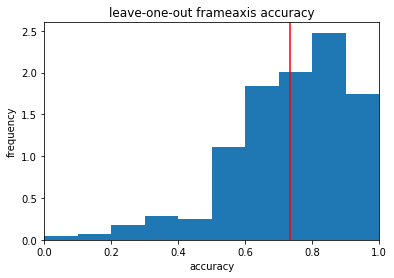

BEST [('abstemious.a.01', 1.0), ('actual.a.01', 1.0), ('armed.a.01', 1.0), ('assisted.a.01', 1.0), ('certain.a.02', 1.0), ('clear.a.01', 1.0), ('competent.a.01', 1.0), ('comprehensible.a.01', 1.0), ('consecrated.a.01', 1.0), ('controversial.a.01', 1.0), ('democratic.a.01', 1.0), ('demonstrative.a.01', 1.0), ('detected.a.01', 1.0), ('determinable.a.01', 1.0), ('dignified.a.01', 1.0), ('diligent.a.02', 1.0), ('effective.a.01', 1.0), ('expressible.a.01', 1.0), ('fallible.a.01', 1.0), ('fit.a.01', 1.0)]
WORST [('left-handed.a.01', 0.0), ('leeward.a.01', 0.0), ('exterior.a.01', 0.0), ('east.a.01', 0.0), ('bidirectional.a.01', 0.0), ('cellular.a.02', 0.125), ('theoretical.a.02', 0.14285714285714285), ('piano.a.01', 0.16666666666666666), ('alkaline.a.01', 0.16666666666666666), ('right.a.01', 0.18181818181818182), ('right-handed.a.01', 0.2), ('frozen.a.01', 0.2), ('compact.a.01', 0.2), ('western.a.02', 0.2222222222222222), ('denotative.a.01', 0.2222222222222222), ('male.a.01', 0.23076923076923

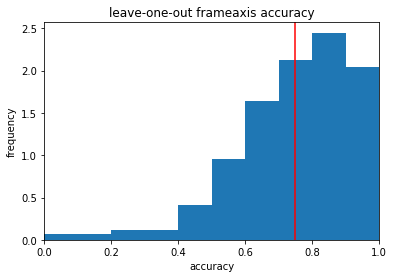

BEST [('abstemious.a.01', 1.0), ('bony.a.03', 1.0), ('certain.a.02', 1.0), ('civilized.a.01', 1.0), ('committed.a.01', 1.0), ('complimentary.a.01', 1.0), ('contented.a.01', 1.0), ('controversial.a.01', 1.0), ('corrigible.a.01', 1.0), ('creative.a.01', 1.0), ('determinable.a.01', 1.0), ('expressible.a.01', 1.0), ('faithful.a.01', 1.0), ('fatty.a.01', 1.0), ('fit.a.01', 1.0), ('forgiving.a.01', 1.0), ('gracious.a.01', 1.0), ('grateful.a.01', 1.0), ('healthful.a.01', 1.0), ('humane.a.02', 1.0)]
WORST [('leeward.a.01', 0.0), ('exterior.a.01', 0.0), ('east.a.01', 0.0), ('bidirectional.a.01', 0.0), ('left-handed.a.01', 0.1), ('left.a.04', 0.125), ('piano.a.01', 0.16666666666666666), ('right.a.01', 0.18181818181818182), ('right-handed.a.01', 0.2), ('frozen.a.01', 0.2), ('denotative.a.01', 0.2222222222222222), ('right.a.07', 0.25), ('professional.a.01', 0.25), ('planned.a.01', 0.25), ('external.a.01', 0.25), ('cellular.a.02', 0.25), ('occupied.a.01', 0.2857142857142857), ('corporeal.a.01', 0.2

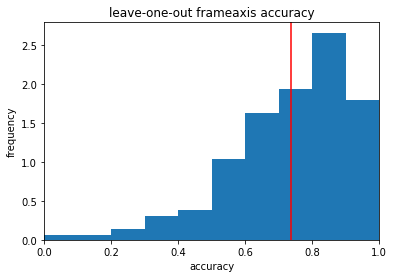

BEST [('abstemious.a.01', 1.0), ('actual.a.01', 1.0), ('armed.a.01', 1.0), ('assisted.a.01', 1.0), ('authorized.a.01', 1.0), ('certain.a.02', 1.0), ('clear.a.01', 1.0), ('competent.a.01', 1.0), ('consecrated.a.01', 1.0), ('controversial.a.01', 1.0), ('demonstrative.a.01', 1.0), ('detected.a.01', 1.0), ('determinable.a.01', 1.0), ('dignified.a.01', 1.0), ('diligent.a.02', 1.0), ('effective.a.01', 1.0), ('expressible.a.01', 1.0), ('fallible.a.01', 1.0), ('fit.a.01', 1.0), ('gracious.a.01', 1.0)]
WORST [('leeward.a.01', 0.0), ('exterior.a.01', 0.0), ('east.a.01', 0.0), ('bidirectional.a.01', 0.0), ('north.a.01', 0.0625), ('negative.a.01', 0.09090909090909091), ('western.a.02', 0.1111111111111111), ('left.a.04', 0.125), ('cellular.a.02', 0.125), ('theoretical.a.02', 0.14285714285714285), ('gradual.a.02', 0.14285714285714285), ('male.a.01', 0.15384615384615385), ('piano.a.01', 0.16666666666666666), ('alkaline.a.01', 0.16666666666666666), ('purebred.a.01', 0.18181818181818182), ('right-hande

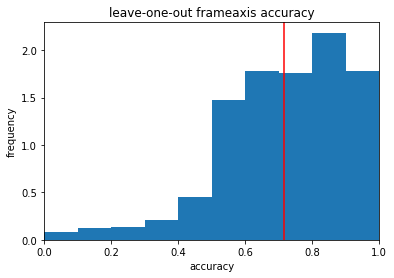

Counter({'abridged.a.01': 0.875,
         'absolute.a.01': 0.8888888888888888,
         'abstemious.a.01': 1.0,
         'abstract.a.01': 0.8,
         'abundant.a.01': 0.5,
         'accessible.a.01': 0.6666666666666666,
         'accordant.a.01': 0.7272727272727273,
         'accurate.a.01': 0.5555555555555556,
         'acknowledged.a.01': 0.9285714285714286,
         'active.a.03': 0.7777777777777778,
         'active.a.05': 0.72,
         'active.a.07': 0.5,
         'actual.a.01': 1.0,
         'adaptable.a.01': 0.6666666666666666,
         'additive.a.02': 0.6666666666666666,
         'adequate.a.01': 0.5,
         'adorned.a.01': 0.717948717948718,
         'adroit.a.01': 0.8636363636363636,
         'adulterating.a.01': 0.875,
         'advantageous.a.01': 0.6,
         'affected.a.01': 0.9285714285714286,
         'affected.a.02': 0.5882352941176471,
         'afferent.a.01': 0.42857142857142855,
         'afraid.a.01': 0.6896551724137931,
         'aggressive.a.01': 0.619047

In [105]:
def plot_axes_quality(quality_file_path):
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    accuracies = Counter()
    for synset in scores: 
        correct = 0
        incorrect = 0
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                if scores[synset][w][0] < 0: 
                    correct += 1
                else: 
                    incorrect += 1
            else: 
                if scores[synset][w][0] >= 0: 
                    correct += 1
                else: 
                    incorrect += 1
        accuracies[synset] = correct/(correct + incorrect)
    ordered_accuracies = accuracies.most_common()
    print("BEST", ordered_accuracies[:20])
    print("WORST", ordered_accuracies[::-1][:20])
    plt.hist(accuracies.values(), density=True)
    plt.xlim(0, 1)
    print("AVG ACCURACY:", np.mean(list(accuracies.values())))
    plt.axvline(x=np.mean(list(accuracies.values())), color='red')
    plt.ylabel('frequency')
    plt.xlabel('accuracy')
    plt.title('leave-one-out frameaxis accuracy')
    plt.show()
    return accuracies
plot_axes_quality(LOGS + 'semantics_val/axes_quality.txt')
accuracies = plot_axes_quality(LOGS + 'semantics_val/axes_quality_scaler.txt')
plot_axes_quality(LOGS + 'semantics_val/axes_quality_kbest.txt')
plot_axes_quality(LOGS + 'semantics_val/axes_quality_pca.txt')